In [4]:
%matplotlib inline

import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co
from celloracle.applications import Gradient_calculator
from celloracle.applications import Oracle_development_module
from celloracle.visualizations.config import CONFIG

In [5]:
links = co.load_hdf5('intermediate_data/3_delile.celloracle.links')
oracle = co.load_hdf5('intermediate_data/3_delile.celloracle.oracle')

In [6]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10,
                              use_cluster_specific_TFdict=True)

  0%|          | 0/2 [00:00<?, ?it/s]

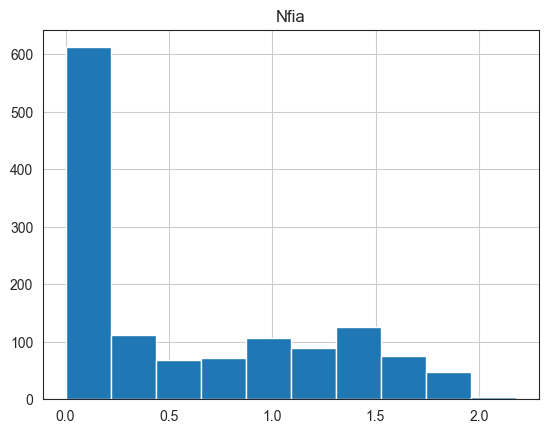

In [7]:
goi = "Nfia"
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

In [8]:
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

In [9]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True,
                                sampled_fraction=1)

# Calculate embedding
oracle.calculate_embedding_shift(sigma_corr=0.05)

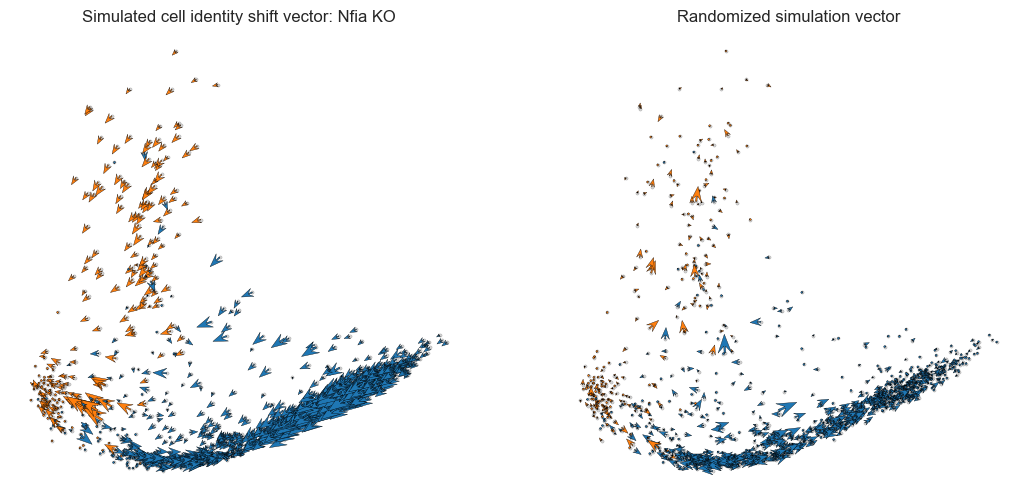

In [10]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 10
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()


In [11]:
# Select first two components for PCA 
oracle.embedding = oracle.embedding[:, :2]  
n_grid = 40
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

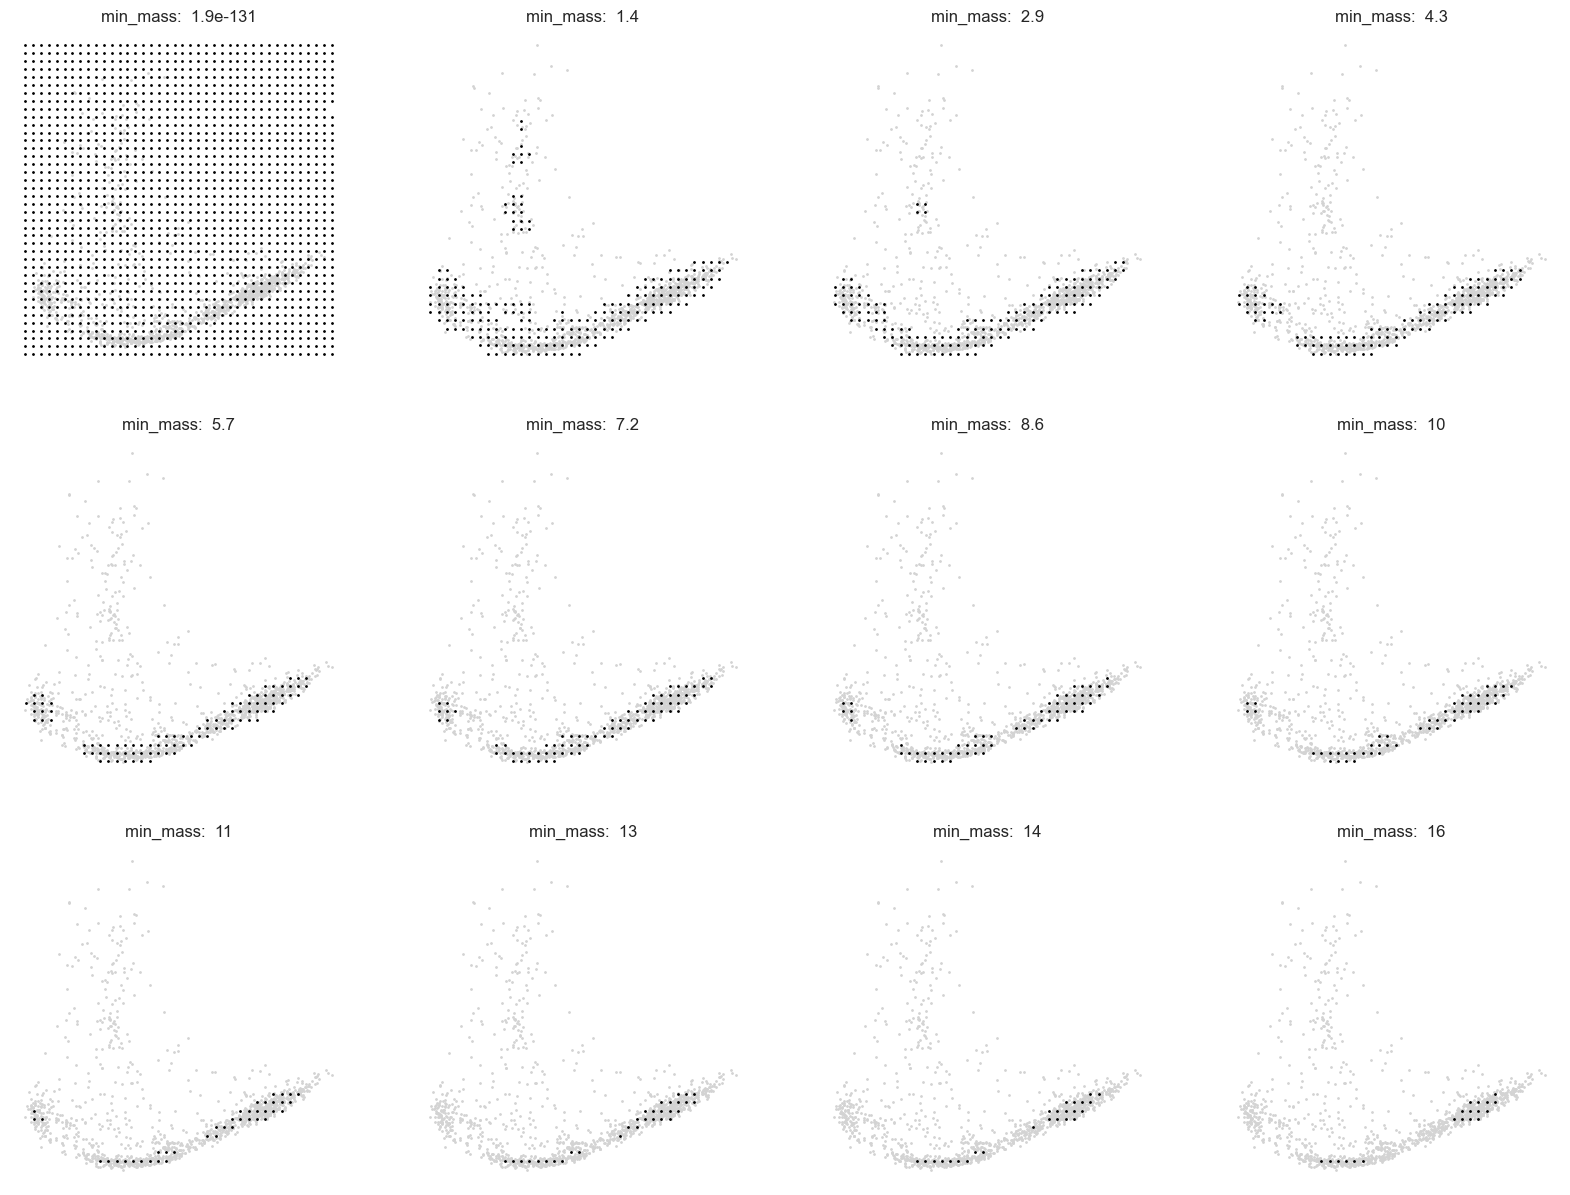

In [12]:
oracle.suggest_mass_thresholds(n_suggestion=12)

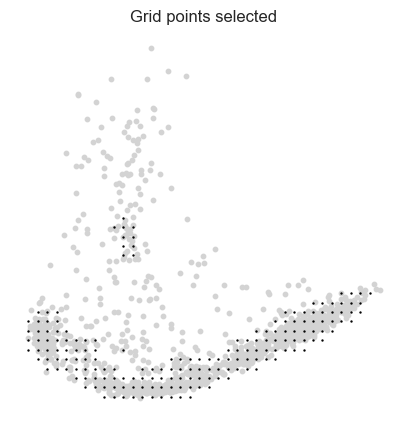

In [13]:
min_mass = 2
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

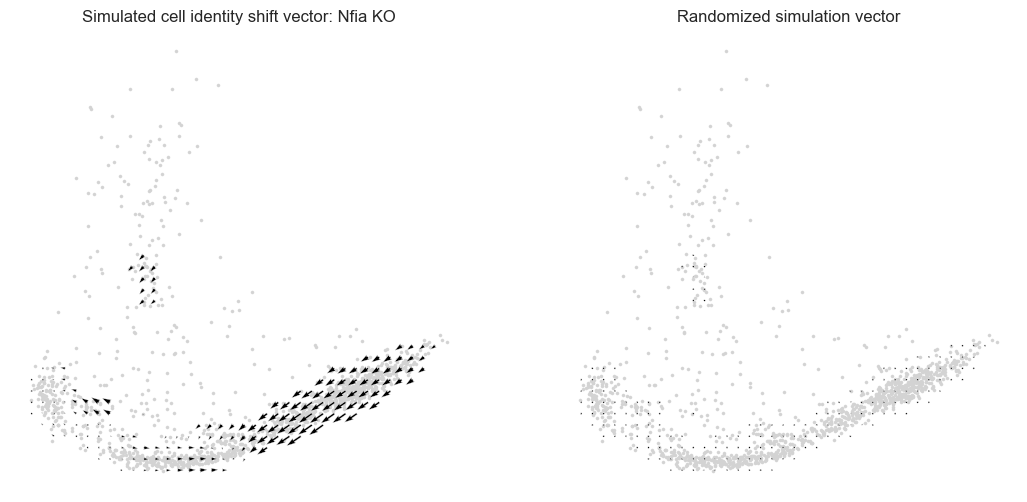

In [14]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 10
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

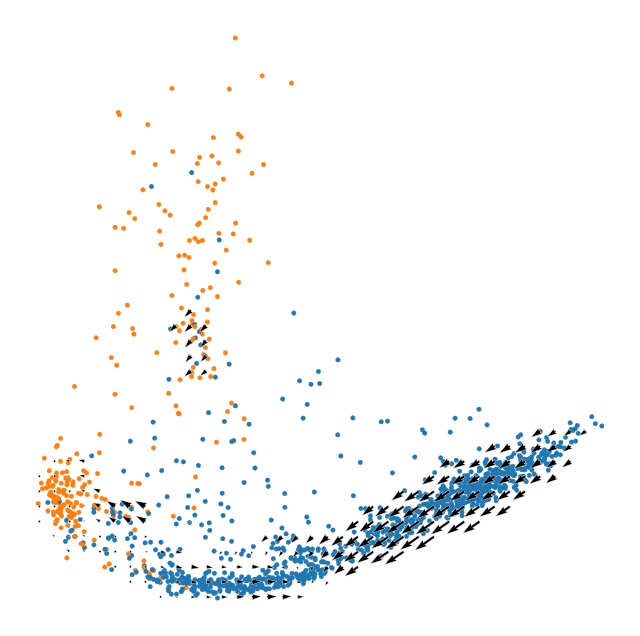

In [15]:
# Plot vector field on cluster
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

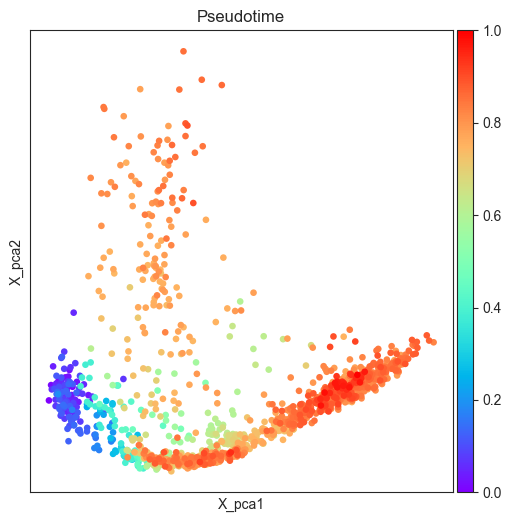

In [16]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["Pseudotime"])

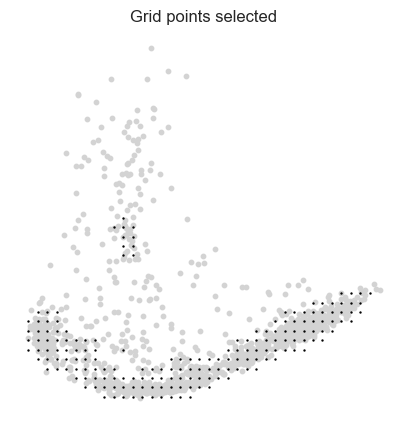

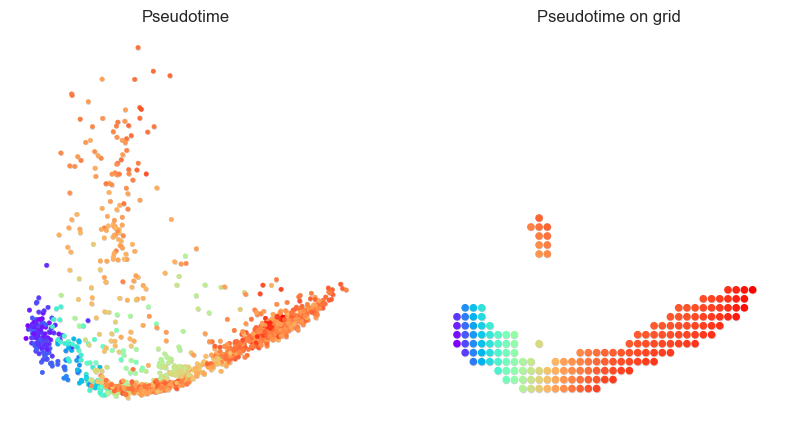

In [17]:
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")
gradient.embedding = gradient.embedding[:, :2]  
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

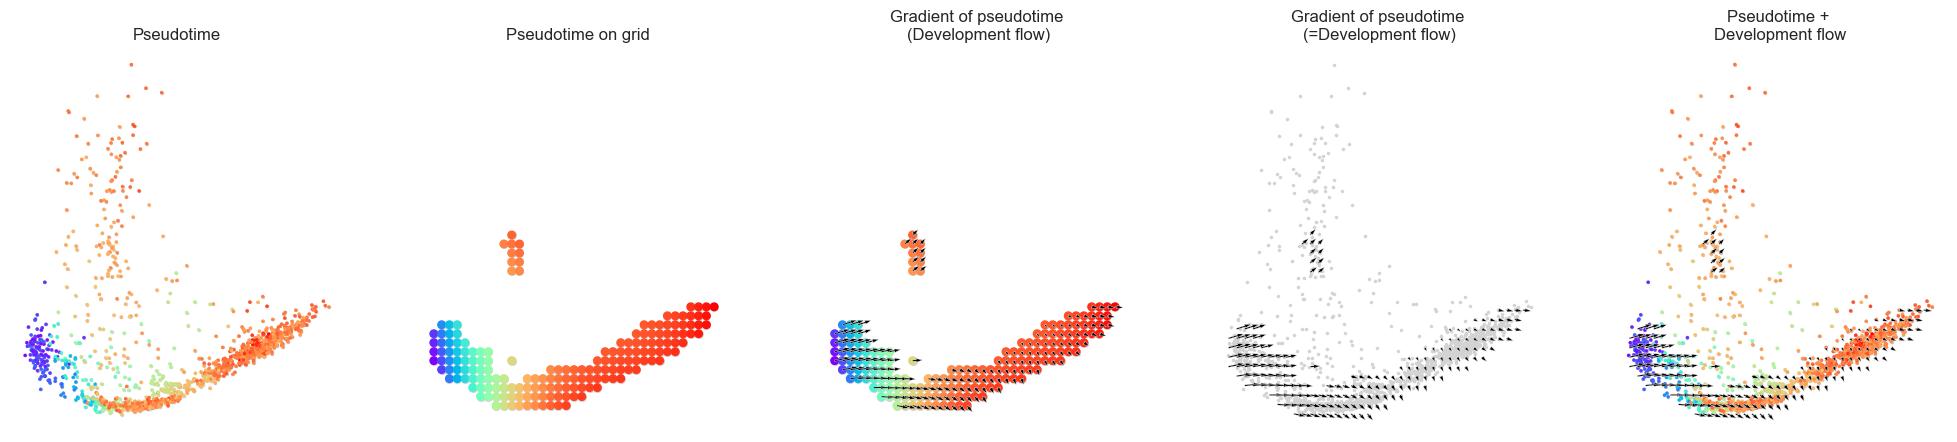

In [18]:
# Calculate gradient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

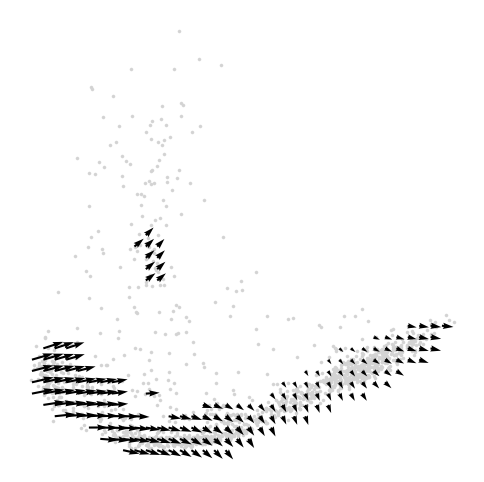

In [19]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [20]:
# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)

# Modify flow to first two components, calculate inner product scores
dev.flow = dev.flow[:, :2]  
dev.flow_rndm = dev.flow_rndm[:, :2]  
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

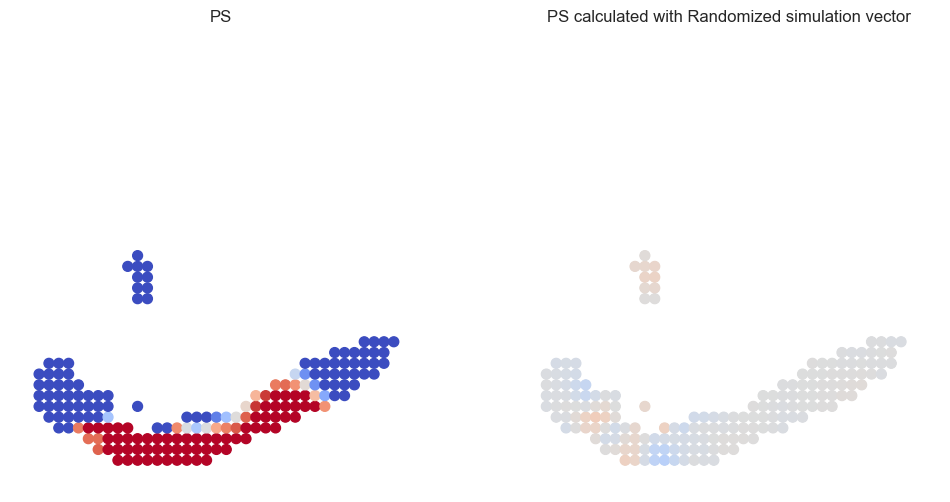

In [21]:
# Show perturbation scores
CONFIG["cmap_ps"] = "coolwarm"
vm = 0.25

fig, ax = plt.subplots(1, 2, figsize=[12, 6])
dev.plot_inner_product_on_grid(vm=0.02, s=50, ax=ax[0])
ax[0].set_title(f"PS")

dev.plot_inner_product_random_on_grid(vm=vm, s=50, ax=ax[1])
ax[1].set_title(f"PS calculated with Randomized simulation vector")
plt.show()

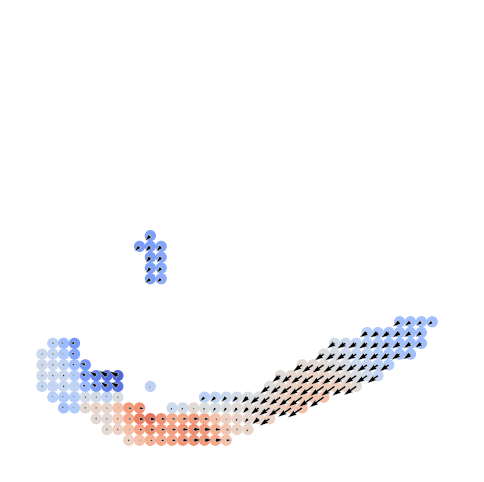

In [22]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=vm, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)